<a href="https://colab.research.google.com/github/Garuooo/Signature-Verification/blob/main/one_shot_sginature_verification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import opendatasets as od
import os
import shutil
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as implt
import random

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer,Conv2D,MaxPooling2D,Input,Flatten,Dense


In [4]:
od.download("https://www.kaggle.com/datasets/robinreni/signature-verification-dataset/")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: garuoo
Your Kaggle Key: ··········


100%|██████████| 601M/601M [00:23<00:00, 26.3MB/s]


In [5]:
path = "/content/signature-verification-dataset/sign_data/sign_data/train"

In [ ]:
dir_list = os.listdir(path)
dir_list.sort()
dir_list[5]

'003_forg'

In [ ]:
dir_list[5]

'003_forg'

In [9]:
def make_embedding():
    inp = Input(shape=(100,100,3),name="input_image")
    c1 = Conv2D(filters=64,kernel_size=(10,10),activation='relu')(inp)
    m1 = MaxPooling2D(64,(2,2),padding="same")(c1)
    c2= Conv2D(filters=128,kernel_size=(7,7),activation="relu")(m1)
    m2 = MaxPooling2D(64,(2,2),padding="same")(c2)
    c3= Conv2D(filters=128,kernel_size=(4,4),activation="relu")(m2)
    m3 = MaxPooling2D(64,(2,2),padding="same")(c3)
    c4= Conv2D(filters=256,kernel_size=(4,4),activation="relu")(m3)
    f1= Flatten()(c4)
    output=Dense(4096,activation='sigmoid')(f1)
    model = Model(inputs=inp,outputs=output,name="embedding")
    return model

In [10]:
class L1Dist(Layer):
    def __init__(self,**kwargs):
        super().__init__()
    
    def call(self,input_embedding,validation_embedding):
        return tf.math.abs(input_embedding-validation_embedding)


In [11]:
def make_siamese_model():
    # input images
    input_image = Input(shape=(100,100,3),name='input_image')
    validation_image = Input(shape=(100,100,3),name='valdiation_image')
    
    # make embedding layer
    embedding = make_embedding()
    
    #combine siamese distances
    siamese_layer = L1Dist()
    distances = siamese_layer(embedding(input_image),embedding(validation_image))
    
    # Classifier Layer
    classifier = Dense(1,activation='sigmoid')(distances)
    
    return Model(inputs=[input_image,validation_image],outputs=[classifier])
    

In [12]:
GENIUENE_PATH = os.path.join("data","GENIUENE")
FORGED_PATH = os.path.join("data","FORGED")
ANC_PATH = os.path.join("data","anchor")

In [13]:
!mkdir data
!mkdir data/GENIUENE
!mkdir data/FORGED

In [14]:
import shutil
        

In [15]:
path = "/content/signature-verification-dataset/sign_data/sign_data/train"
for directory in os.listdir(path):
    if directory.find("forg")==-1:
       shutil.move(os.path.join(path,directory),GENIUENE_PATH)
    else:
        shutil.move(os.path.join(path,directory),FORGED_PATH)


In [16]:
forged_dir = os.listdir("/content/data/FORGED")
geniuene_dir = os.listdir("/content/data/GENIUENE")
len(forged_dir)

64

In [17]:
negative = tf.data.Dataset.list_files("/content/data/FORGED"+"/*"+"/*").take(100)
positive =  tf.data.Dataset.list_files("/content/data/GENIUENE/"+geniuene_dir[0]+"/*").take(100)
positive_2 = tf.data.Dataset.list_files("/content/data/GENIUENE/"+geniuene_dir[0]+"/*").take(100)

positives = tf.data.Dataset.zip(((positive, positive_2), tf.data.Dataset.from_tensor_slices(tf.ones(len(positive)))))
negatives = tf.data.Dataset.zip(((positive, negative), tf.data.Dataset.from_tensor_slices(tf.zeros(len(negative)))))

data = positives.concatenate(negatives)

In [18]:
for i in range(0,64):
    negative = tf.data.Dataset.list_files("/content/data/FORGED"+"/*"+"/*").take(100)
    positive =  tf.data.Dataset.list_files("/content/data/GENIUENE/"+geniuene_dir[i]+"/*").take(100)
    positive_2 = tf.data.Dataset.list_files("/content/data/GENIUENE/"+geniuene_dir[i]+"/*").take(100)

    positives = tf.data.Dataset.zip(((positive, positive_2), tf.data.Dataset.from_tensor_slices(tf.ones(len(positive)))))
    negatives = tf.data.Dataset.zip(((positive, negative), tf.data.Dataset.from_tensor_slices(tf.zeros(len(negative)))))

    data = data.concatenate(negatives)
    data = data.concatenate(positives)


In [19]:
for i in range(0,64):
    positive =  tf.data.Dataset.list_files("/content/data/GENIUENE/"+geniuene_dir[i]+"/*").take(100)
    for q in range(0,64):
        if q == i:
            continue
        negative = tf.data.Dataset.list_files("/content/data/GENIUENE/"+geniuene_dir[q]+"/*").take(100)
        negatives = tf.data.Dataset.zip(((positive, negative), tf.data.Dataset.from_tensor_slices(tf.zeros(len(negative)))))

        data = data.concatenate(negatives)

In [20]:
data = data.shuffle(3000)


In [21]:
data.as_numpy_iterator().next()


((b'/content/data/GENIUENE/027/09_027.png',
  b'/content/data/GENIUENE/027/08_027.png'),
 1.0)

In [22]:
def preprocess(filepath):
    #read image from file path
    byte_img = tf.io.read_file(filepath)
    #load in the image
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img,size=(100,100))
    img = tf.cast(img,tf.float32)/255.0
    return img

In [23]:
data.as_numpy_iterator().next()

((b'/content/data/GENIUENE/064/12_064.png',
  b'/content/data/FORGED/020_forg/02_0127020.PNG'),
 0.0)

In [24]:
def preproces_helper(images,label):
    return ((preprocess(images[0]),preprocess(images[1])),label)

In [25]:
# build a dataloader pipeline
data = data.map(preproces_helper)
data = data.prefetch(16)
data.cache()

<CacheDataset element_spec=((TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None)), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [26]:
# training dataset
train_data = data.take(round(len(data)*0.05))
# turn training data into batches
train_data =train_data.batch(32)

In [27]:
test_data = data.skip(round(len(data)*0.05)).take(round(len(train_data)*0.05))
#turn test_data into batches
test_data = test_data.batch(32)

In [28]:
type(train_data),len(train_data)

(tensorflow.python.data.ops.dataset_ops.BatchDataset, 81)

In [ ]:
siamese_model = make_siamese_model()
siamese_model.compile(loss=tf.keras.losses.binary_crossentropy,optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),metrics=["accuracy"])

siamese_history = siamese_model.fit(train_data,use_multiprocessing=True, epochs=50 , validation_data=test_data)

Epoch 1/50
81/81 [==============================] - 67s 767ms/step - loss: 0.4172 - accuracy: 0.7912 - val_loss: 0.2186 - val_accuracy: 1.0000
Epoch 2/50
81/81 [==============================] - 54s 617ms/step - loss: 0.3693 - accuracy: 0.8064 - val_loss: 0.0569 - val_accuracy: 1.0000
Epoch 3/50
81/81 [==============================] - 53s 606ms/step - loss: 0.3772 - accuracy: 0.8060 - val_loss: 0.7181 - val_accuracy: 0.7500
Epoch 4/50
81/81 [==============================] - 53s 605ms/step - loss: 0.3365 - accuracy: 0.8138 - val_loss: 0.0830 - val_accuracy: 1.0000
Epoch 5/50
81/81 [==============================] - 52s 596ms/step - loss: 0.3327 - accuracy: 0.8095 - val_loss: 0.0729 - val_accuracy: 1.0000
Epoch 6/50
81/81 [==============================] - 53s 605ms/step - loss: 0.3263 - accuracy: 0.8044 - val_loss: 0.0545 - val_accuracy: 1.0000
Epoch 7/50
81/81 [==============================] - 52s 589ms/step - loss: 0.3033 - accuracy: 0.8150 - val_loss: 0.0262 - val_accuracy: 1.0000

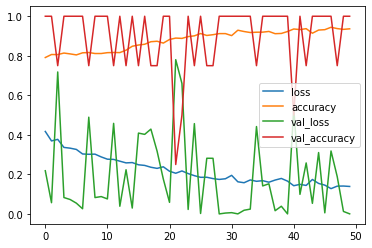

In [ ]:
pd.DataFrame(siamese_history.history).plot()

In [ ]:
siamese_model.evaluate(test_data)

1/1 [==============================] - 17s 17s/step - loss: 0.0017 - accuracy: 1.0000


[0.0016556379850953817, 1.0]

In [ ]:
# Save weights
siamese_model.save('siamesemodel_updated.tf')

In [ ]:
siamese_history

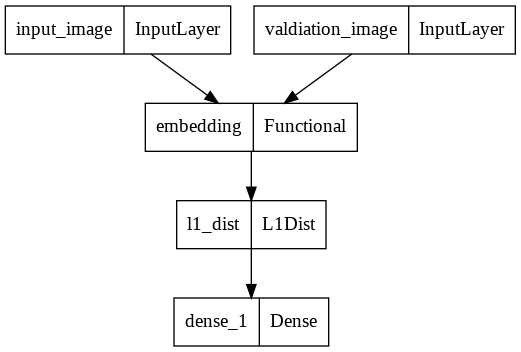

In [ ]:
tf.keras.utils.plot_model(siamese_model)

In [ ]:
path_1 ="/content/data/GENIUENE/001/001_01.PNG"
path_2 = "/content/data/GENIUENE/001/001_06.PNG"
siamese_model.predict((tf.expand_dims(preprocess(path_1),axis=0),tf.expand_dims(preprocess(path_2),axis=0)))

1/1 [==============================] - 0s 92ms/step


array([[0.7915941]], dtype=float32)